# Interpreting SqueezeNet1.1 trained to detect defects in steel sheet 

### 1. Requirments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

In [2]:
### Fast import of Captum Algorithm
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    GuidedBackprop,
    LayerGradCam,
    visualization
)

### 2. Parameters

In [3]:
MODEL_PATH = '../model/OfficialBinaryModels/AugmentedSqueezeReduced10.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/binaryData'
METADATA_PATH = '../data/binaryData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test_binary.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test_binary.pth'

In [4]:
n_classes = 2
class_labels = {0: 'No Defects', 1: 'Defects'}

params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [5]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [6]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


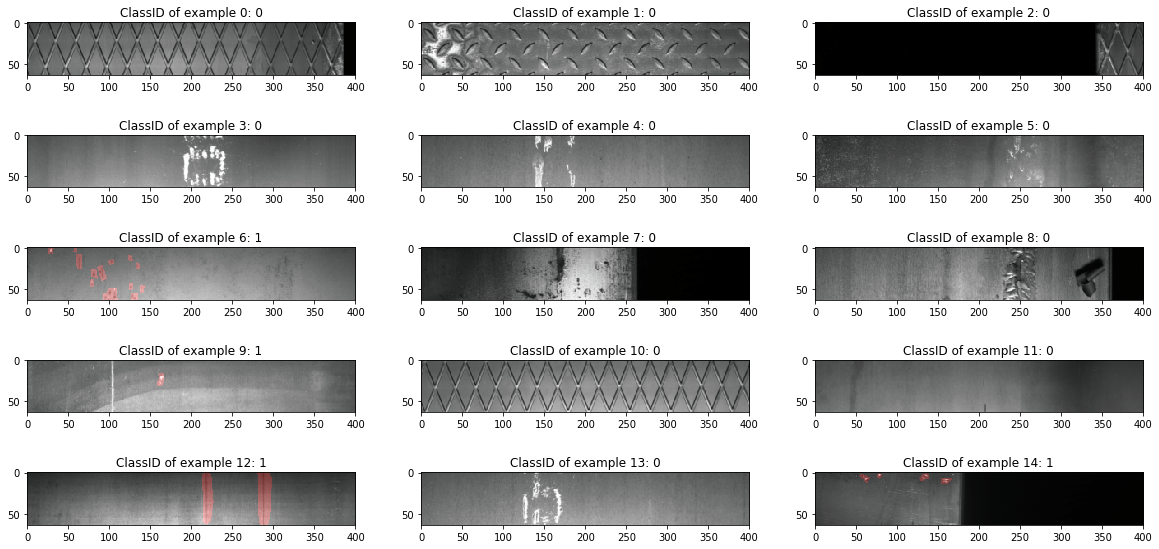

In [7]:
fig, ax = plt.subplots(5, 3, figsize=(20, 10))
start = 0
for i in range(start, start+15):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### 4. Model

    a) Load Squeeze architecture
    b) Modify the classifier architecture
    c) Load the parameters
    d) Move model in GPU

In [8]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 2))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [9]:
y_pred = []
y_true = []
y_score = torch.Tensor([])
batch_size = 5

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        if type(net.classifier[-1]) != torch.nn.modules.activation.Softmax: 
            probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)))

100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [00:13<00:00, 38.44it/s]

Accuracy: 0.9390	F1 Score: 0.9423


In [10]:
fp = y_pred[(y_pred == 1) & (y_true == 0)]
fn = y_pred[(y_pred == 0) & (y_true == 1)]
print(fp.shape[0], fn.shape[0])

index = np.arange(0, y_pred.shape[0])
fp_index = index[(y_pred == 1) & (y_true == 0)]
fn_index = index[(y_pred == 0) & (y_true == 1)]
print('False Positive: {}'.format(fp_index))
print('False Negative: {}'.format(fn_index))

80 73
False Positive: [  24   32   94  236  269  284  341  351  360  445  450  451  460  461
  463  486  521  538  597  599  622  656  678  698  770  850  868  873
  976  995 1001 1037 1151 1163 1213 1269 1274 1305 1346 1358 1364 1383
 1398 1408 1439 1440 1474 1481 1490 1498 1509 1520 1538 1540 1541 1549
 1554 1572 1671 1676 1689 1706 1741 1821 1832 1858 1902 1929 1960 1976
 1995 2013 2046 2114 2211 2219 2237 2280 2413 2455]
False Negative: [ 135  220  233  239  289  316  318  475  542  556  580  601  649  660
  667  689  783  809  847  929  950 1009 1128 1184 1224 1243 1287 1336
 1367 1401 1432 1443 1469 1489 1495 1542 1548 1588 1597 1624 1667 1682
 1753 1771 1781 1807 1839 1880 1933 1956 1958 1980 1981 2011 2033 2063
 2077 2082 2094 2117 2160 2174 2179 2187 2203 2244 2342 2378 2396 2406
 2418 2441 2505]


### 6. Interpretation

In [11]:
def visualize_input(n):
    fig, ax = plt.subplots(1, 1, fgsize=(14, 5))
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[n].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])]
    ax.imshow(img)
    ax.set_title('True class: {}'.format(class_labels[int(y_true[n])]))

    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    plt.show()


def visualize_gradcam(n, module, out_type='id', normalizer=False, color_normalizer=True, return_output = False):
    ### 7.3.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[n].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])]
    ax.imshow(img)
    
    ax.set_title('Input image')

    ### 7.3.b) Initialize GradCam passing the network and the last Convolutional Layer and the results tensor
    grad_cam = c_explainers.GradCam(net, module, device)
    results = torch.Tensor([])    

    ### 7.3.c) Compute GradCam for both target (No Defect/Defect)
    for i in range(n_classes):
        ### 7.3.c.i)  Compute Grad Cam with out_type 'id'. It means that no ReLU operation is done on the GradCam output
        _, original_out = grad_cam(X_val[n], i, out_type='id', interpolation_mode = cv2.INTER_LANCZOS4,  additional_out = True)
        ### 7.3.c.ii) Save the results
        grad_cam_output = cv2.resize(original_out.numpy(), (25*16, 4*16))
        results = torch.cat([results, torch.tensor(grad_cam_output).unsqueeze(0)])

    ### 7.3.d) Normalize the results     
    if normalizer:
        gc_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))
        gc_results = gc_results*2 - 1
    else:
        gc_results = results

    ### 7.3.e) Show GradCam outcomes
    fig = plt.figure(figsize = (16.8, 3.0*n_classes))                            ### Set figure                   
    for j in range(n_classes):          
        ax = fig.add_subplot(n_classes, 1, j+1)                                  ### Addsubplot to figure
        img_input = gc_results[j].numpy()                                        ### Get normalized GradCam output
        img_input[0, 0] = 1
        img_input[0, 1] = -1

        ### 7.3.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 7.3.e.ii) Plot GradCam outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('GradCAM: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()
    return gc_results

def visualize_deeplift(n, normalizer=False, color_normalizer=True):
    ### 8.1.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    ax.imshow(img)
    ax.set_title('Input image')

    ### 8.1.b) Initialize DeepLift passing the network, initialize the baseline
    dl = DeepLift(net)
    baseline = torch.zeros((1, 3, 64, 400)).to(device)
    baseline.requires_grad = True
    results = torch.Tensor([])
    deltas = []

    ### 8.1.c) Compute DeepLift for both target (No Defect/Defect)
    for i in range(2):
        ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
        output, delta = dl.attribute(X_val[n].view(1, *X_val[n].size()).to(device), baseline, i, return_convergence_delta=True)
        ### 8.1.c.ii) Save the results
        deltas.append(float(delta))
        results = torch.cat((results, output.view(1, 3, 64, 400).detach().cpu()))

    ### 8.1.d) Normalize the results
    if normalizer:
        dl_results = ((results - torch.min(results)) / (torch.max(results) - torch.min(results))).mean(dim=1)
    else:
        dl_results = results
        
        
    ## 8.1.d) Show DeepLift outcomes
    fig = plt.figure(figsize = (16.8, 6))                                        ### Set figure                   
    for j in range(2):
        ax = fig.add_subplot(2, 1, j+1)                                          ### Addsubplot to figure
        img_input = dl_results[j].numpy()                                        ### Get normalized DeepLift output

        ### 8.1.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 8.1.e.ii) Plot DeepLift outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('DeepLift: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()

### GradCAM

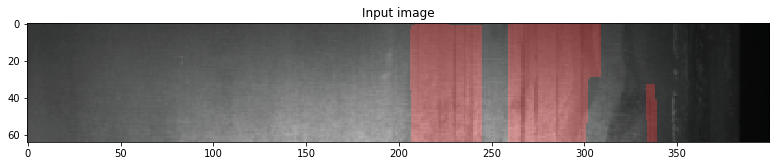

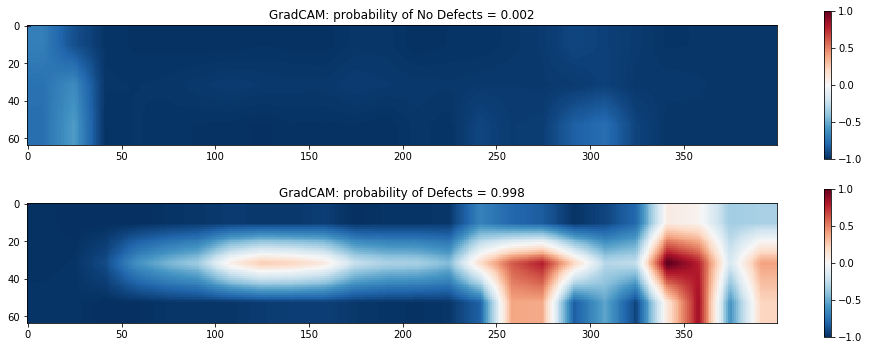

In [100]:
n = 16
res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False, return_output=True)

### DeepSHAP

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


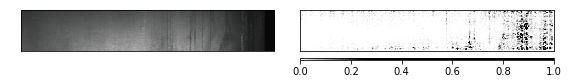

In [101]:
np.random.seed(0)

from matplotlib.colors import LinearSegmentedColormap
gradient_shap = DeepLiftShap(net)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

input = X_val[n].unsqueeze(0).to(device)
transformed_img = np.transpose(input.squeeze(0).cpu().numpy(), (1, 2, 0))*params['std'] + params['mean']

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          #n_samples=50,
                                          #stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=1).cpu().detach().squeeze()
_ = visualization.visualize_image_attr_multiple(np.transpose(attributions_gs.numpy(), (1,2,0)),
                                      transformed_img,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

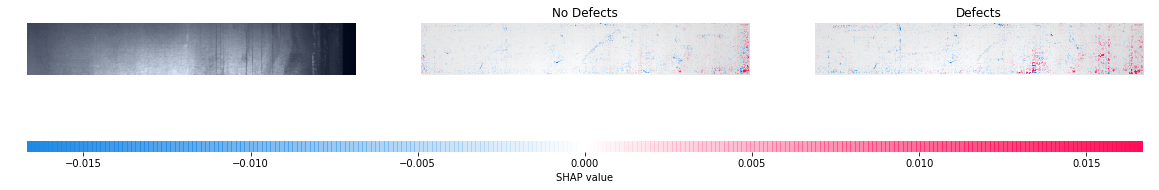

In [102]:
### 7.2.a) Define Backgrund using the next 15 following images in the batch
background = X_val[n+1:n+40].to(device)
### 7.2.b) Init the explainer passing to it the Network and the backgorund
e = shap.DeepExplainer(net.to(device), background)
inp_img = X_val[n].view(1, *list(X_val[n].shape))

### 7.2.c) Compute the shap values for the input X. Input must be 4D (B, C, H, W) and in GPU.
shap_values = e.shap_values(inp_img.to(device)) 

### 7.2.d) Display results
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]                  ### Reshape shap values
test_numpy = np.swapaxes(np.swapaxes(inp_img.cpu().numpy(), 1, -1), 1, 2)                     ### Reshape input example
test_numpy = (test_numpy - test_numpy.min()) / (test_numpy.max() - test_numpy.min())          ### Normalize     
class_labels_shap = np.array([i for i in class_labels.values()]).reshape(1, n_classes)        ### Define Class Labels
shap.image_plot(shap_numpy, test_numpy, class_labels_shap, figsize=(20, 8))                 ### Plot

### Multiple inputs

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


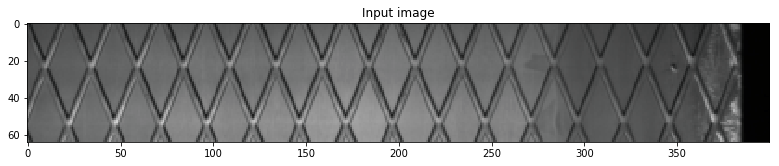

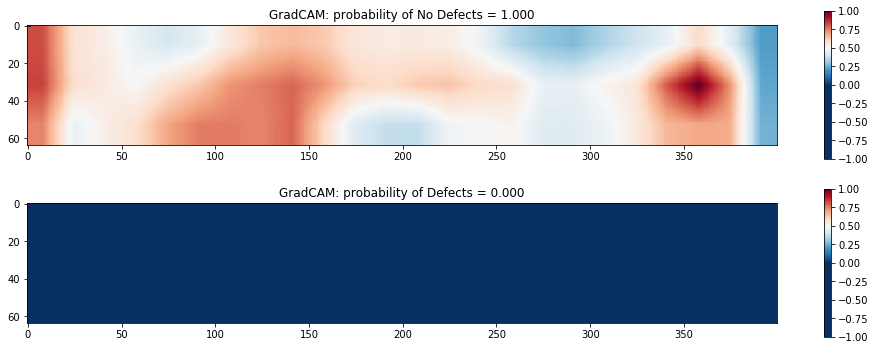

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


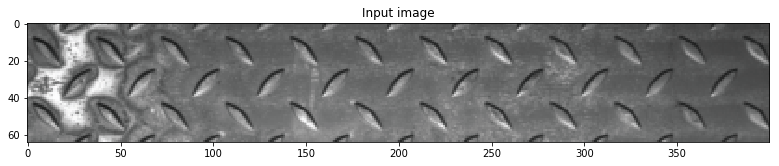

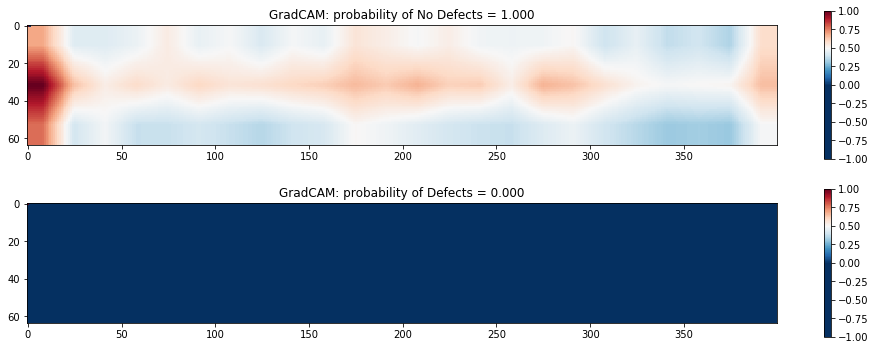

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


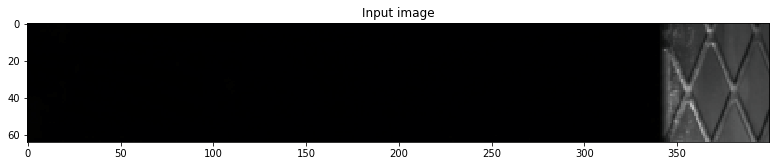

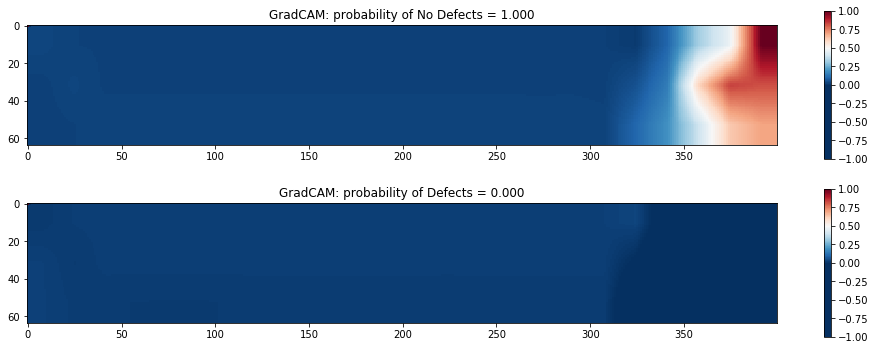

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


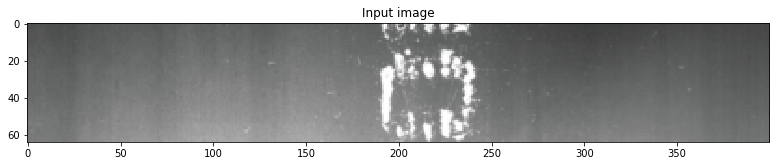

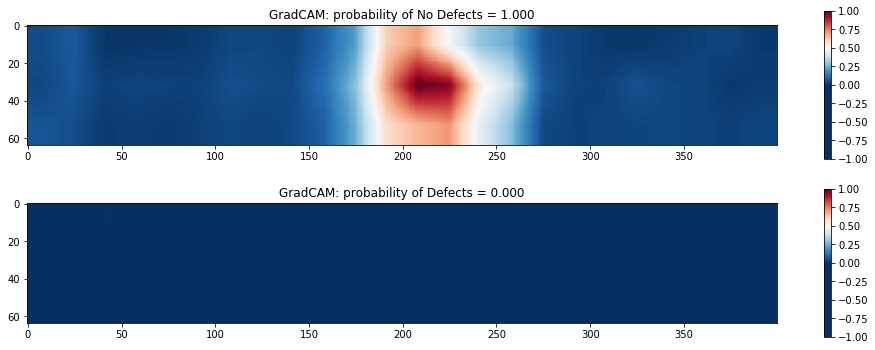

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


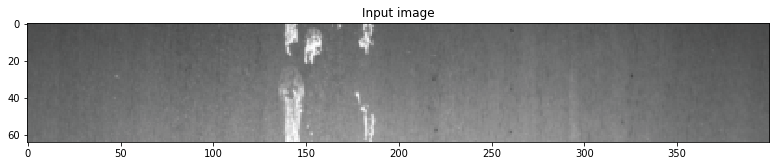

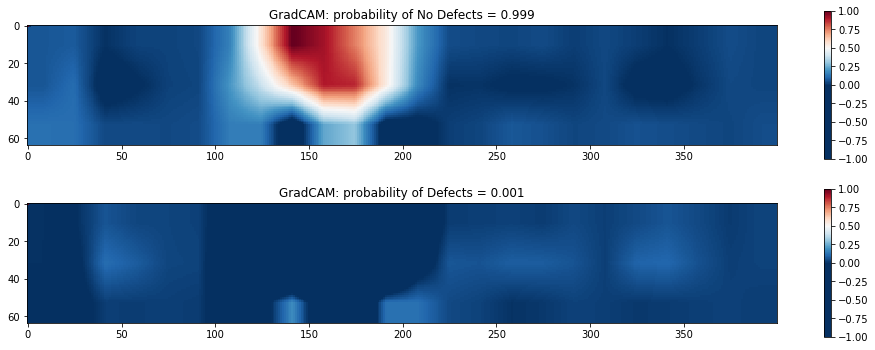

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


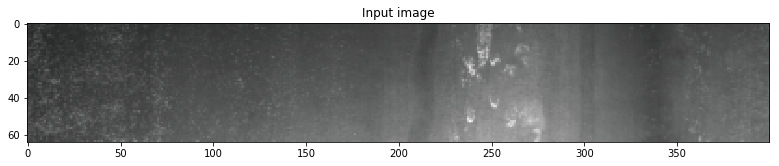

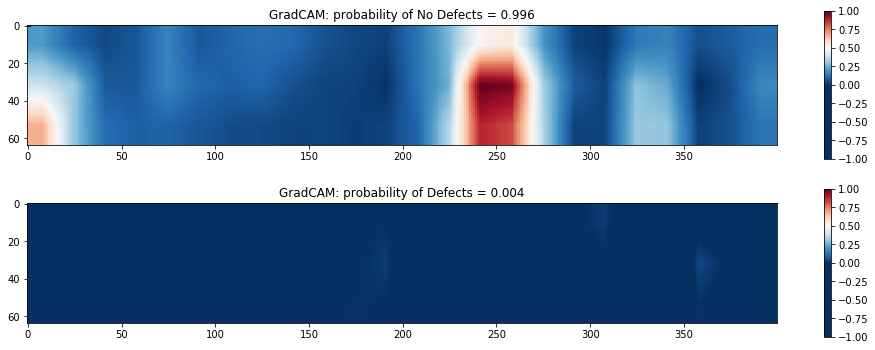

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


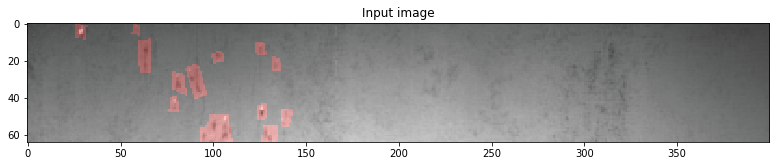

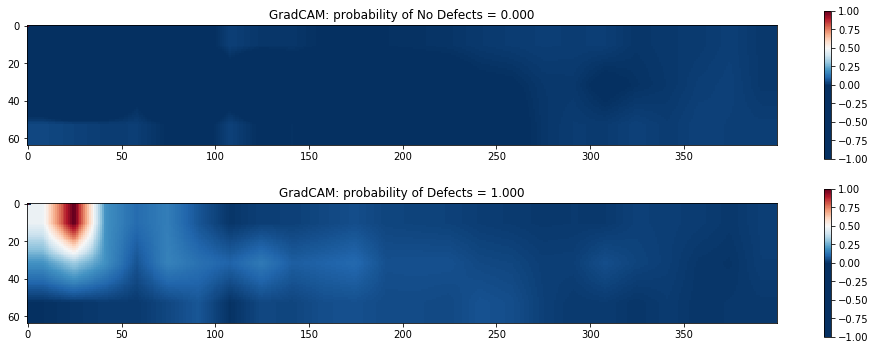

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


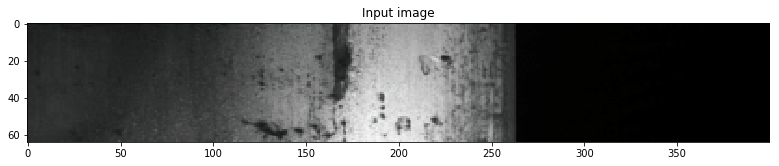

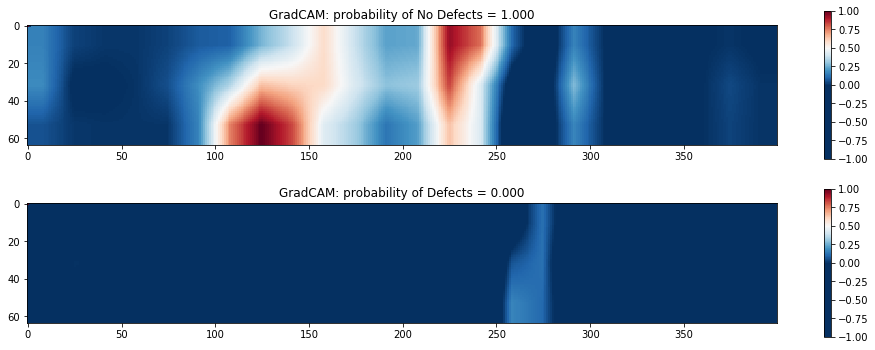

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


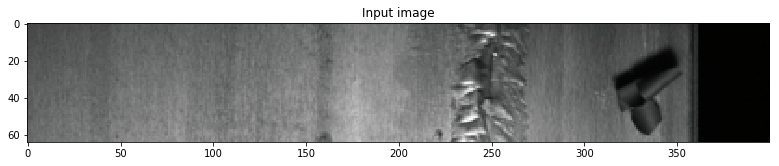

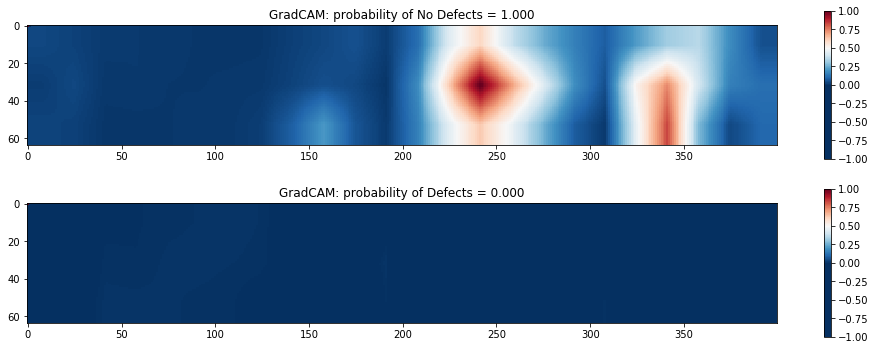

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


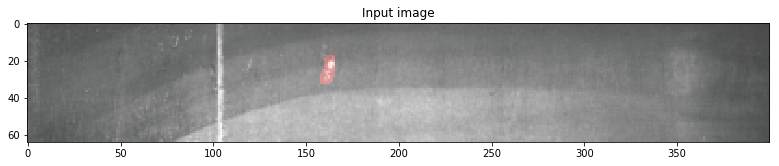

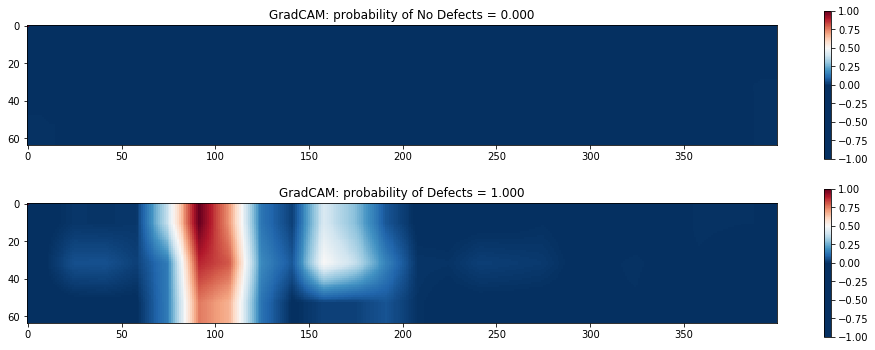

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


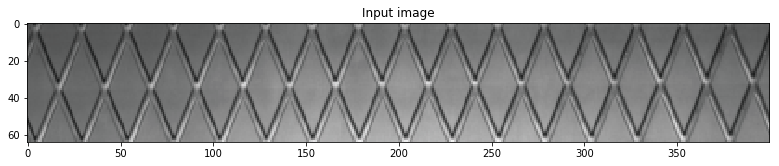

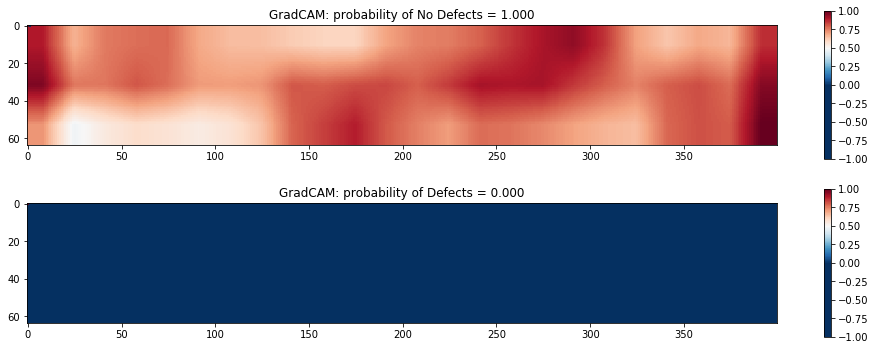

The model predicted correctly:	True
Predicted No Defects with probability:	0.94
Predicted Defects with probabability:	0.06


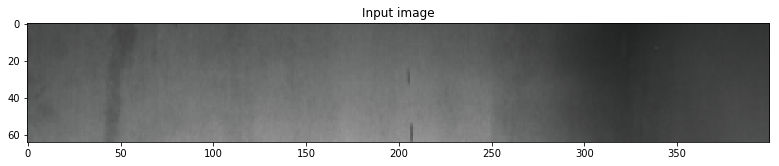

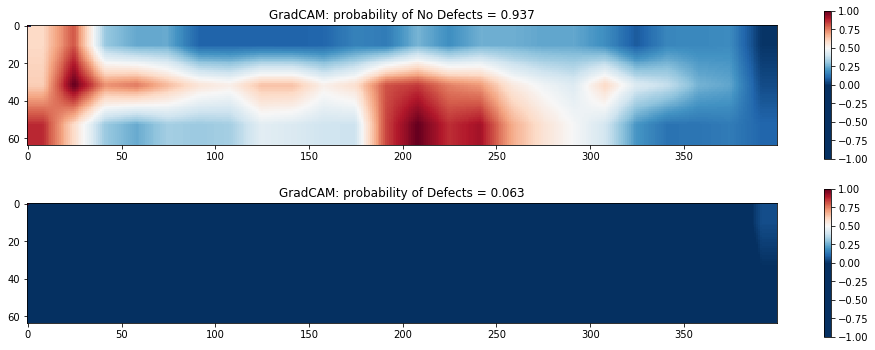

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


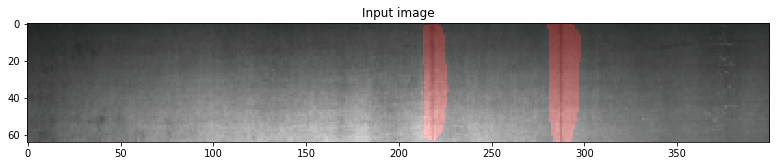

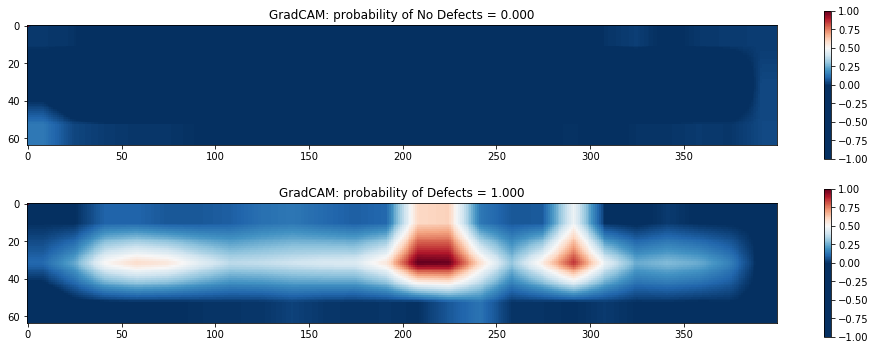

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


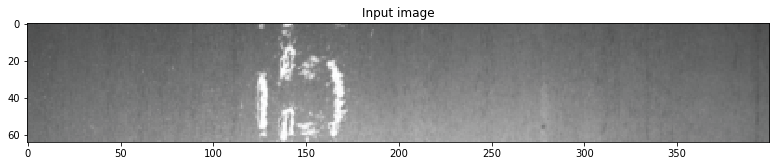

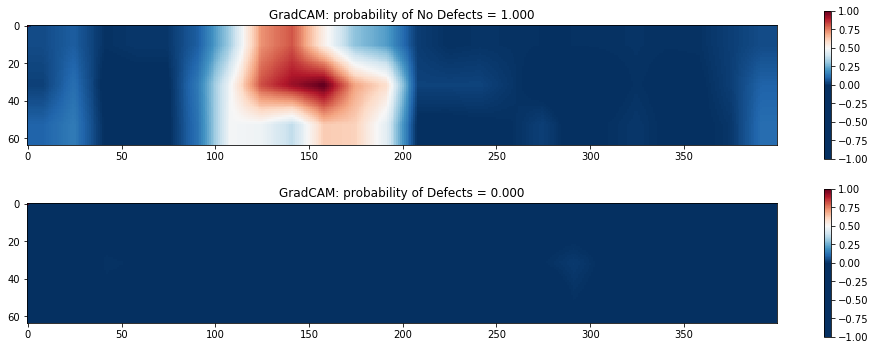

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


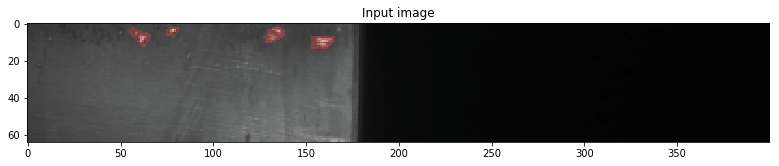

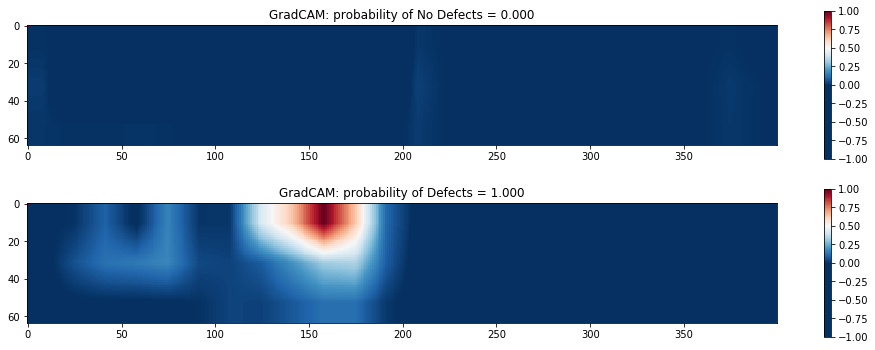

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


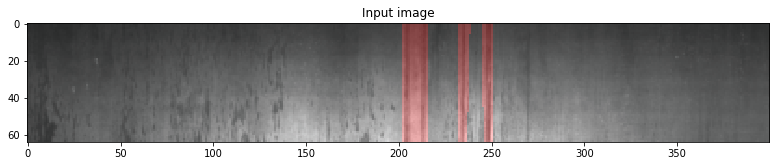

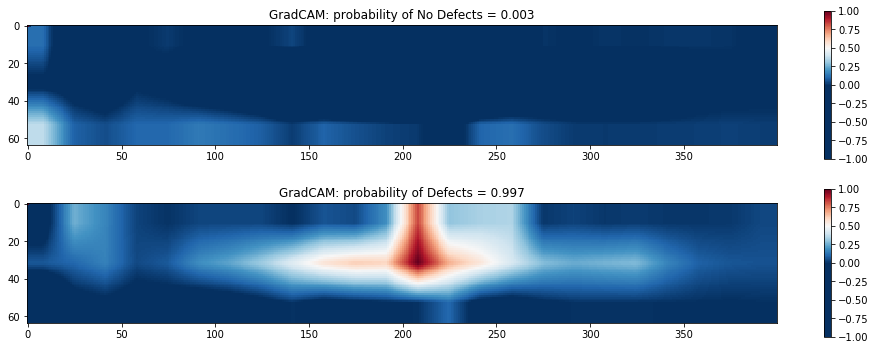

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


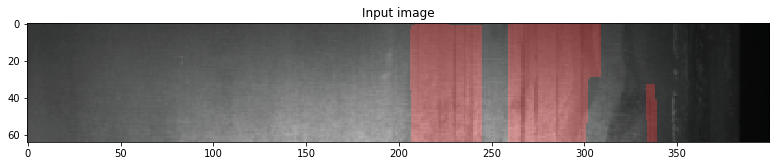

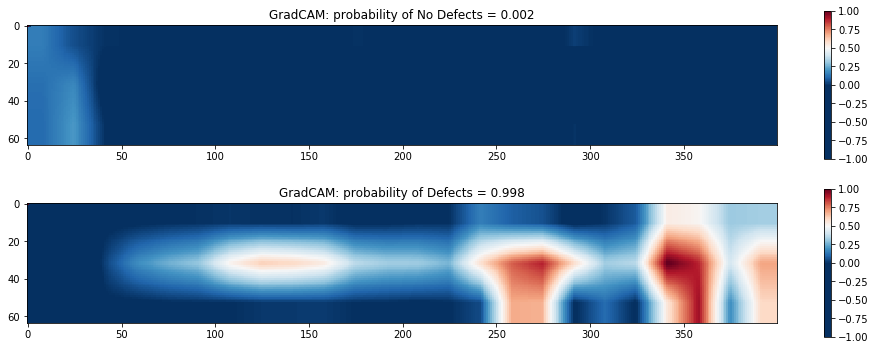

The model predicted correctly:	True
Predicted No Defects with probability:	0.01
Predicted Defects with probabability:	0.99


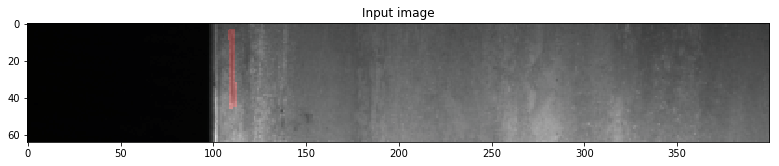

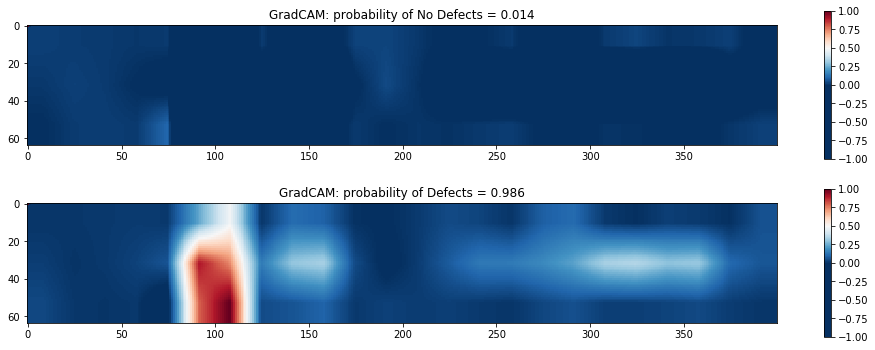

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


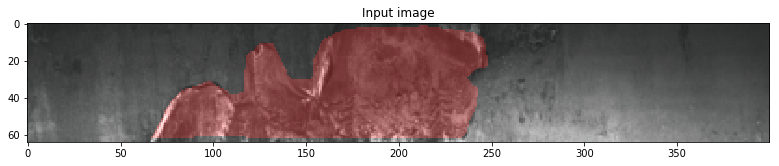

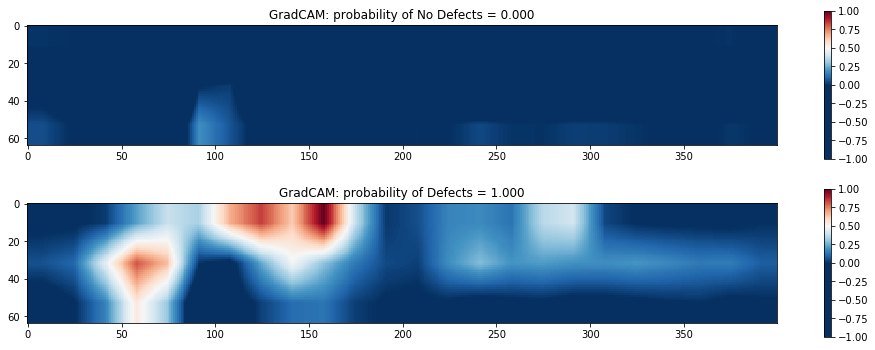

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


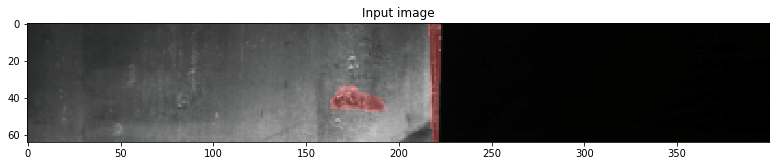

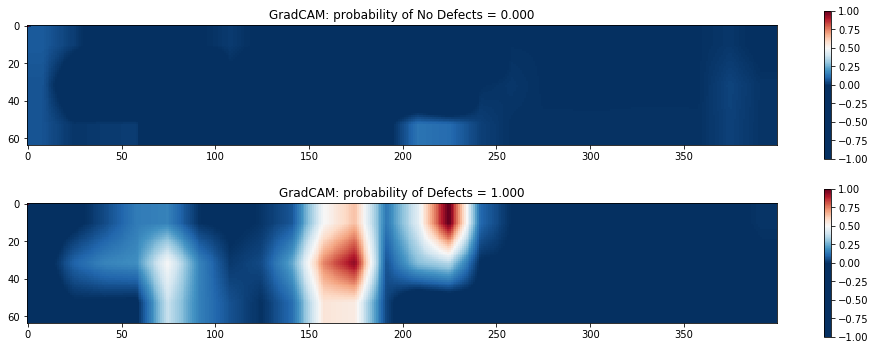

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


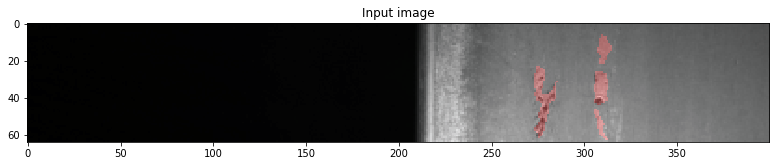

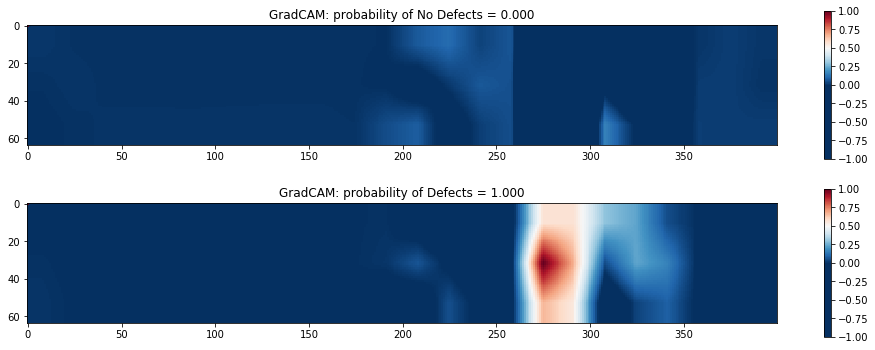

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


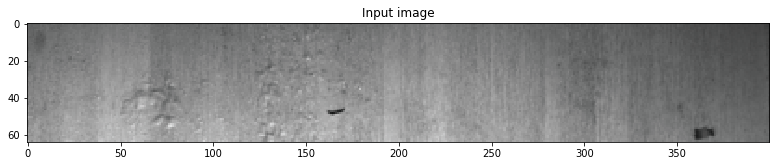

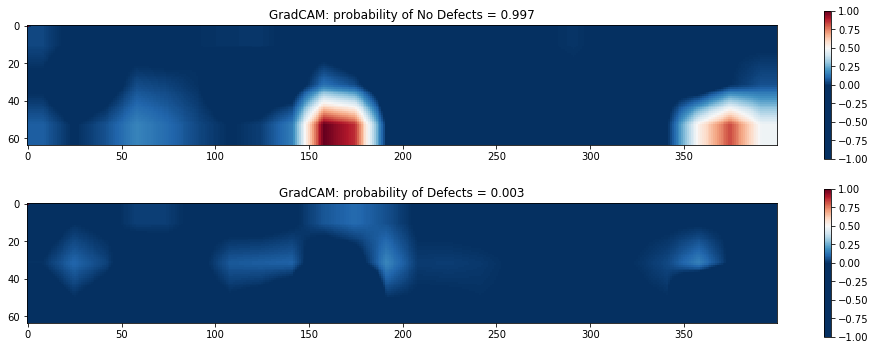

The model predicted correctly:	True
Predicted No Defects with probability:	0.97
Predicted Defects with probabability:	0.03


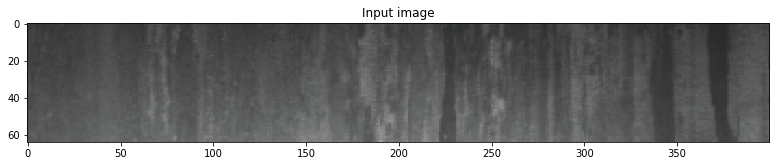

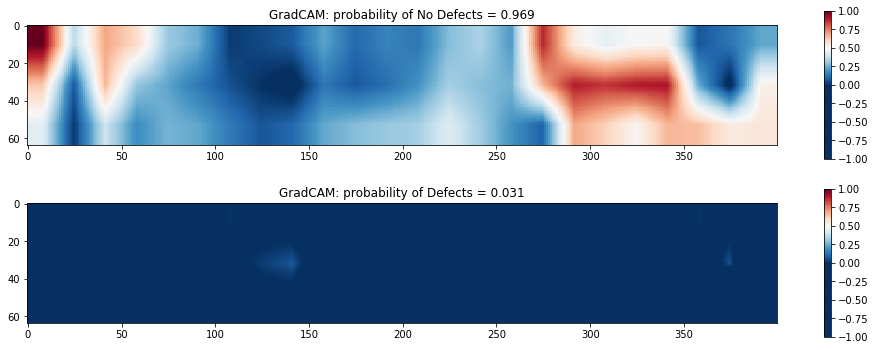

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


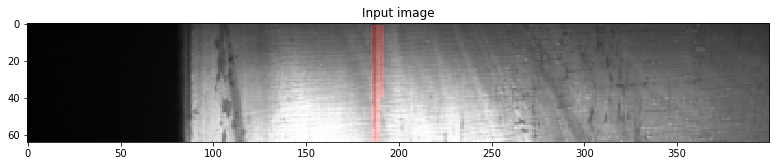

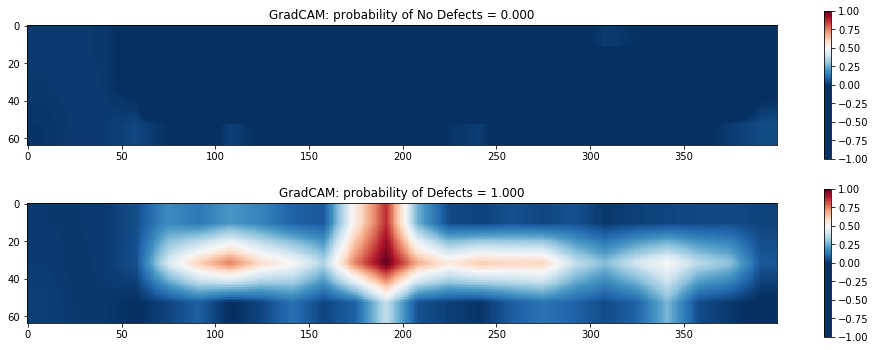

In [14]:
for n in range(24):
    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    #visualize_input(n)
    visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=True)

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


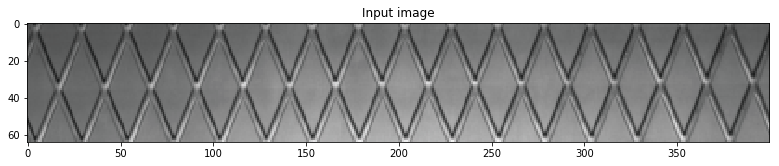

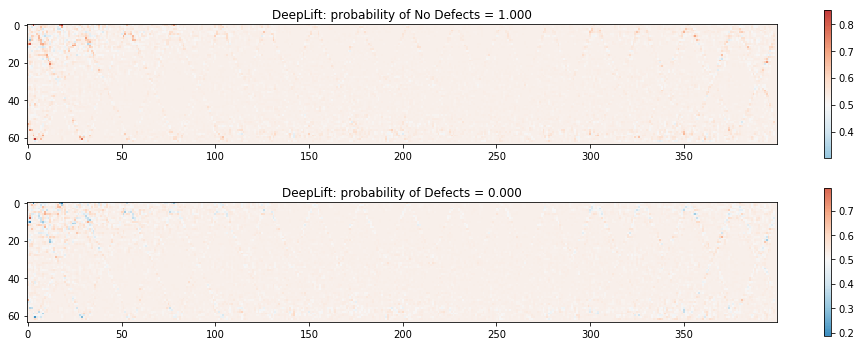

The model predicted correctly:	True
Predicted No Defects with probability:	0.99
Predicted Defects with probabability:	0.01


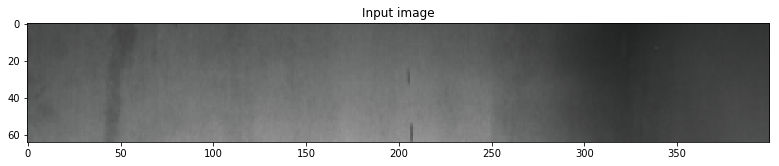

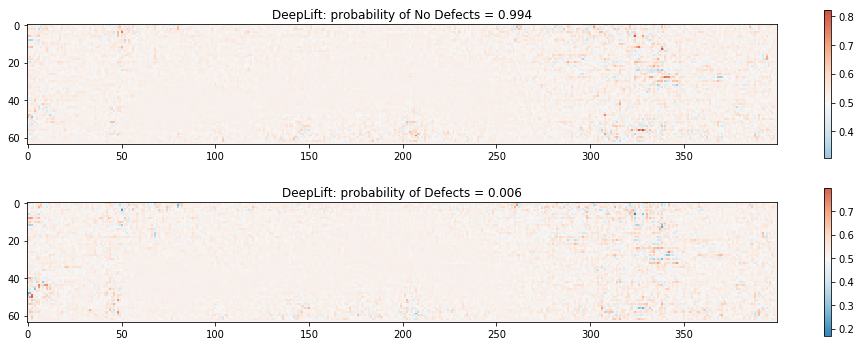

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


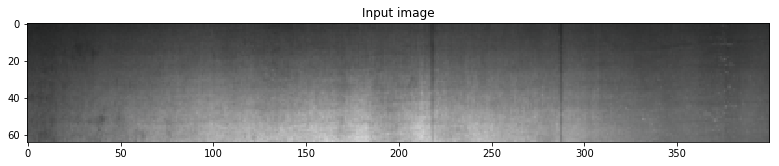

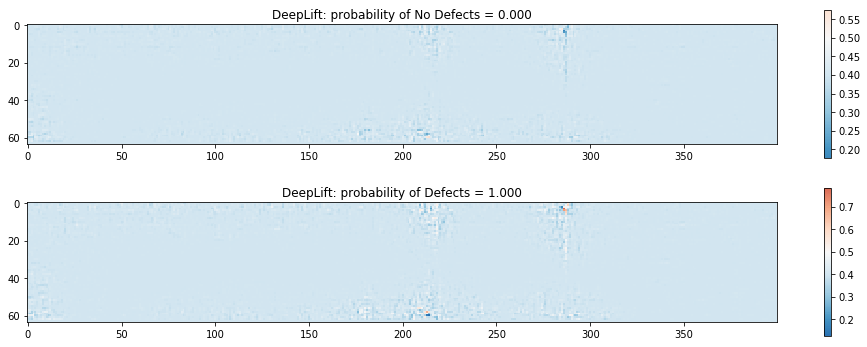

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


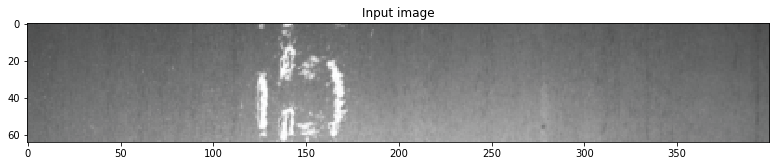

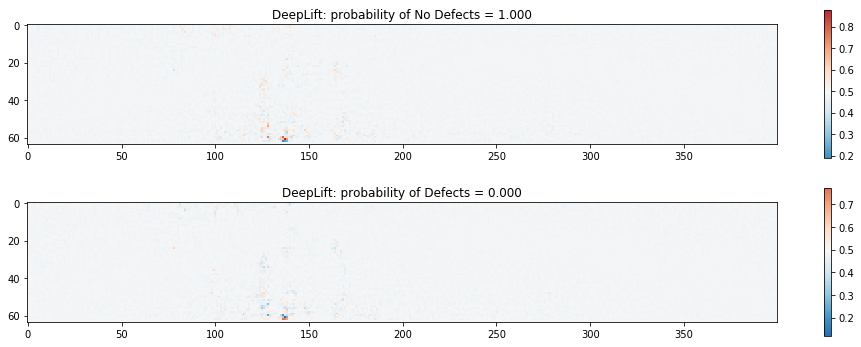

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


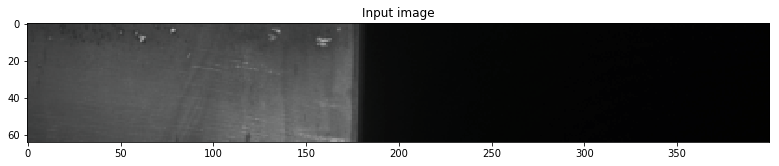

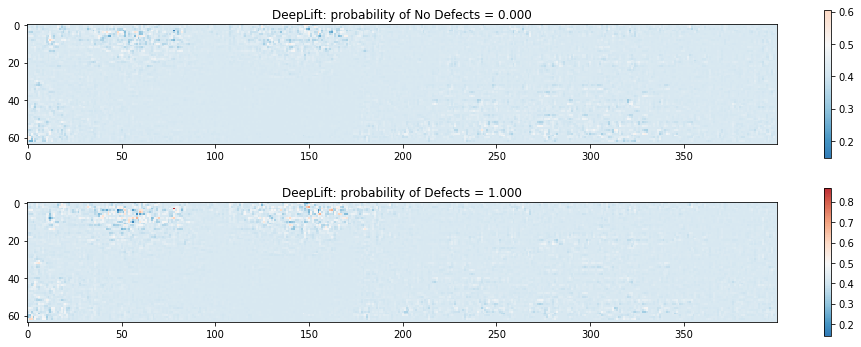

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


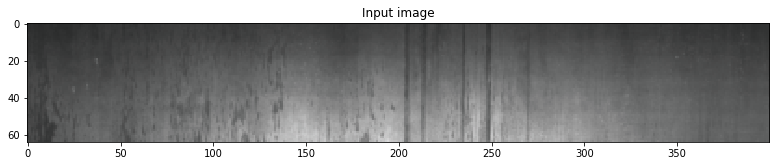

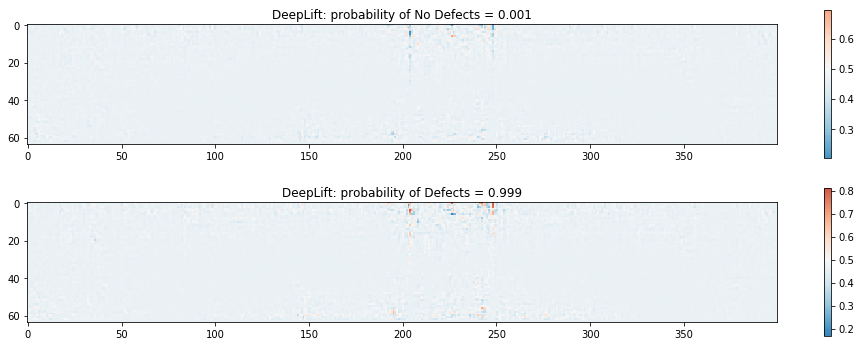

The model predicted correctly:	True
Predicted No Defects with probability:	0.01
Predicted Defects with probabability:	0.99


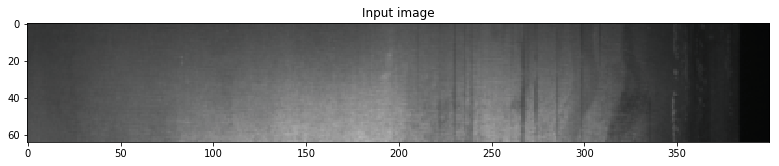

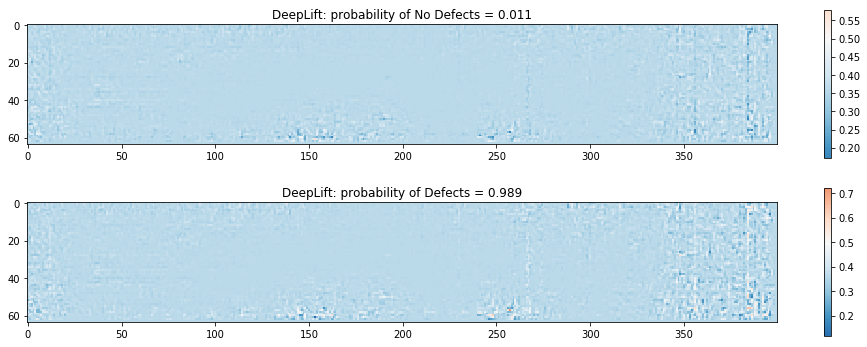

The model predicted correctly:	True
Predicted No Defects with probability:	0.01
Predicted Defects with probabability:	0.99


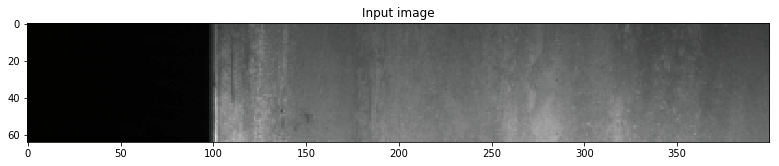

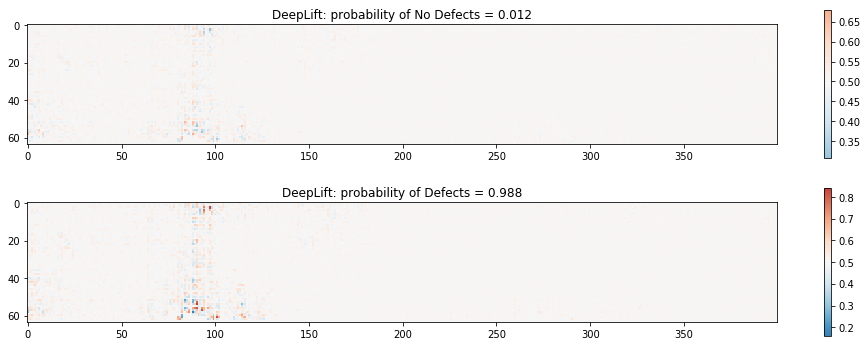

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


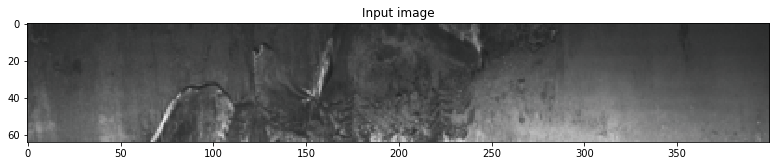

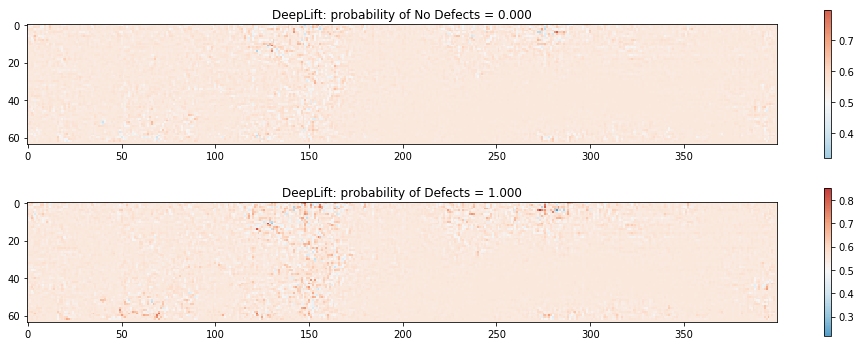

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


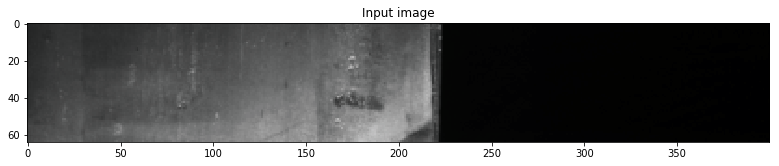

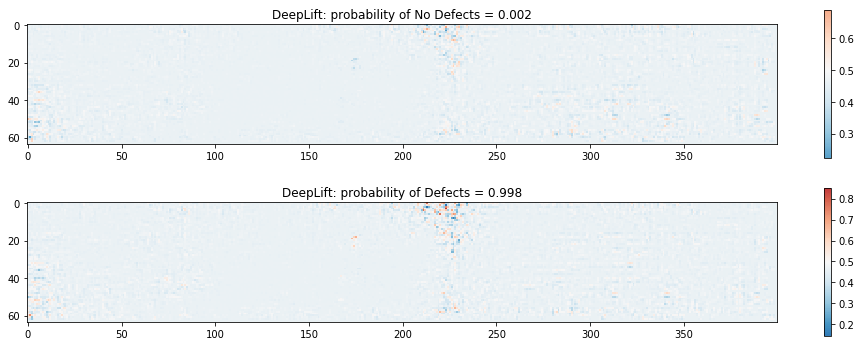

In [14]:
for n in range(10, 20):
    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    #visualize_input(n)
    visualize_deeplift(n, normalizer=True, color_normalizer=True)

### Segmentation Evaluation 

In [62]:
def mask_score(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    y = y_true + y_pred
    tp = y[y==2].shape[0]
    tn = y[y==0].shape[0]
    fp = y[(y_true == 0) & (y_pred == 1)].shape[0]
    fn = y[(y_true == 1) & (y_pred == 0)].shape[0]
    
    return {'accuracy': (tp+tn)/(tp+tn+fp+fn),'recall': (0.01 + tp)/(0.01 + tp+fn), 
            'precision': (0.01 + tp)/(0.01+tp+fp), 'dice_score': (0.01+tp)/(0.01+tp+fp+fn)} 

In [56]:
X, Y, M = X_val[y_val == 1], y_val[y_val == 1], M_val[y_val == 1]

### DeepLift

In [63]:
dl = DeepLift(net)
baseline = torch.zeros((1, 3, 64, 400)).to(device)
baseline.requires_grad = True
accuracy, recall, precision, dice = [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = dl.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().sum(axis=0).cpu()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(7, 7))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy.append(res['accuracy'])
    recall.append(res['recall'])
    precision.append(res['precision'])
    dice.append(res['dice_score'])
np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(dice)

100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [02:15<00:00,  9.77it/s]


(0.8450560897435897,
 0.5237927663649042,
 0.14689575683495013,
 0.10915935686694282)

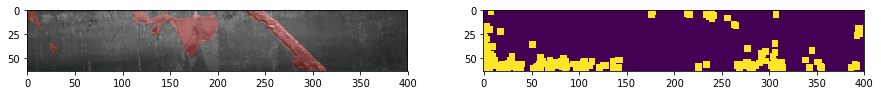

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### Integrated Gradient

In [65]:
ig = IntegratedGradients(net)
baseline = torch.zeros((1, 3, 64, 400)).to(device)
baseline.requires_grad = True
accuracy_ig, recall_ig, precision_ig, dice_ig = [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = ig.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().sum(axis=0).cpu()
    x.detach().cpu()
    b_out = cv2.blur(output.numpy(), ksize=(7, 7))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy_ig.append(res['accuracy'])
    recall_ig.append(res['recall'])
    precision_ig.append(res['precision'])
    dice_ig.append(res['dice_score'])
np.mean(accuracy_ig), np.mean(recall_ig), np.mean(dice_ig), np.mean(precision_ig)

100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [05:37<00:00,  3.93it/s]


(0.5013722249717194,
 0.6468538025044136,
 0.05699877564838155,
 0.06482304678798913)

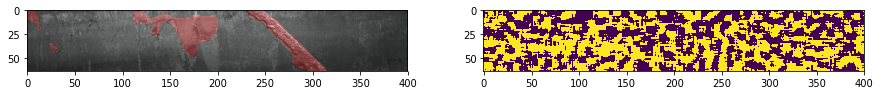

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### GuidedBackProp

In [57]:
bp = GuidedBackprop(net)
accuracy_bp, recall_bp, precision_bp, dice_bp = [], [], [], []
    
for i in tqdm(range(X[:20].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = bp.attribute(x.unsqueeze(0).to(device), Y[i]).squeeze().detach().mean(axis=0).cpu()
    x.detach().cpu()
    mean_out = 0 + 2*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy_bp.append(res['accuracy'])
    recall_bp.append(res['recall'])
    precision_bp.append(res['precision'])
    dice_bp.append(res['dice_score'])
np.mean(accuracy_bp), np.mean(recall_bp), np.mean(precision_bp), np.mean(dice_bp)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.21it/s]


(0.89038671875, 0.6743798060817177, 0.23818826857577524, 0.17578266297606027)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


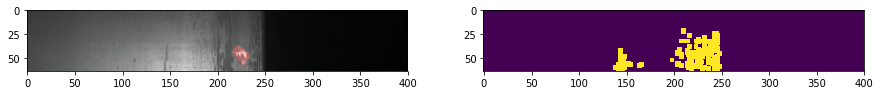

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### GuidedGradCam

In [81]:
ggc = GuidedGradCam(net, net.classifier[1])
accuracy_ggc, recall_ggc, precision_ggc, dice_ggc = [], [], [], []
    
for i in tqdm(range(X[:20].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = ggc.attribute(x.unsqueeze(0).to(device), Y[i]).squeeze().detach().mean(axis=0).cpu()
    x.detach().cpu()
    mean_out = 0 + 2*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), b_out)
    accuracy_ggc.append(res['accuracy'])
    recall_ggc.append(res['recall'])
    precision_ggc.append(res['precision'])
    dice_ggc.append(res['dice_score'])
np.mean(accuracy_ggc), np.mean(recall_ggc), np.mean(precision_ggc), np.mean(dice_ggc)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.55it/s]


(0.920666015625, 0.49365304358405016, 0.2790558347376215, 0.17247727295668164)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


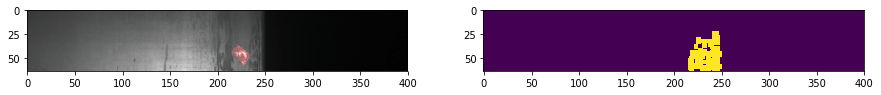

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### GradCam

In [89]:
gc = LayerGradCam(net, net.classifier[1])
accuracy_gc, recall_gc, precision_gc, dice_gc = [], [], [], []
    
for i in tqdm(range(X[:18].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = gc.attribute(x.unsqueeze(0).to(device), Y[i], relu_attributions=True).squeeze().detach().cpu().numpy()
    output = cv2.resize(output, (400, 64))
    x.detach().cpu()
    mean_out = 0 + 2*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output, ksize=(1, 1))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), b_out)
    accuracy_gc.append(res['accuracy'])
    recall_gc.append(res['recall'])
    precision_gc.append(res['precision'])
    dice_gc.append(res['dice_score'])
np.mean(accuracy_gc), np.mean(recall_gc), np.mean(precision_gc), np.mean(dice_gc)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 47.27it/s]


(0.8803754340277776,
 0.47302136692051305,
 0.1530681934071005,
 0.10897107128186859)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


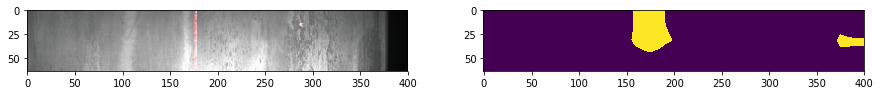

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()

### NoiseGradCam

In [14]:
gc = LayerGradCam(net, net.classifier[1])
nt = NoiseTunnel(gc)
accuracy_gc, recall_gc, precision_gc, dice_gc = [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = nt.attribute(x.unsqueeze(0).to(device), target=Y[i], n_samples=20, stdevs = 0.1).squeeze().detach().cpu().numpy()
    #output = gc.attribute(x.unsqueeze(0).to(device), target=Y[i]).squeeze().detach().cpu().numpy()
    output = cv2.resize(output, (400, 64))
    x.detach().cpu()
    mean_out = 0 + 1*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output, ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), output)
    accuracy_gc.append(res['accuracy'])
    recall_gc.append(res['recall'])
    precision_gc.append(res['precision'])
    dice_gc.append(res['dice_score'])
np.mean(accuracy_gc), np.mean(recall_gc), np.mean(precision_gc), np.mean(dice_gc)

100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:56<00:00, 23.30it/s]


(0.8281144242552791,
 0.6346695739797389,
 0.14316220304329474,
 0.11646669905000043)

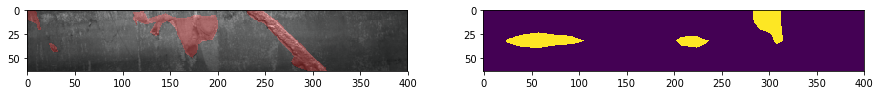

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()

### DeepShap

In [16]:
dl = DeepLiftShap(net)
baseline = X_val[:25].to(device)
baseline.requires_grad = True
accuracy, recall, precision, dice = [], [], [], []
    
for i in tqdm(range(X[25:100].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = dl.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().mean(axis=0).cpu().numpy()
    x.detach()
    mean_out = 0 + 1.5*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
#     b_out = cv2.blur(output.numpy(), ksize=(7, 7))
#     b_out[b_out > 0] = 1
#     b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), output)
    accuracy.append(res['accuracy'])
    recall.append(res['recall'])
    precision.append(res['precision'])
    dice.append(res['dice_score'])
np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(dice)

  0%|                                                                                           | 0/75 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s]


(0.9116432291666664,
 0.13473843483637413,
 0.230741364623054,
 0.06827336172649592)

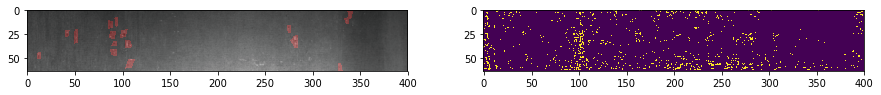

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()